In [1]:
import sys
import os

# Add the src directory to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Analyses - Descriptives

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from utils.output_data_preprocess import *

## Load data

In [3]:
file = "dolphin-2.8-mistral-7b-v02__chatbot_arena_conv__ASI__2025-01-23_16-56"
# dolphin-2.8-mistral-7b-v02__chatbot_arena_conv__ASI__2025-01-08_22-59
# dolphin-2.8-mistral-7b-v02__persona_hub__ASI__2025-01-21_01-02
# Mistral-7B-Instruct-v0.3__chatbot_arena_conv__ASI__2024-12-30_19-25
# Mistral-7B-Instruct-v0.3__persona_hub__ASI__2025-01-04_02-54

# Random answer option order:
# dolphin-2.8-mistral-7b-v02__chatbot_arena_conv__ASI__2025-01-23_16-56
# Mistral-7B-Instruct-v0.3__chatbot_arena_conv__ASI__2025-01-20_18-13

# dolphin-2.8-mistral-7b-v02__chatbot_arena_conv__MSS__2025-01-10_22-50
# dolphin-2.8-mistral-7b-v02__persona_hub__MSS__2025-01-10_20-49
# Mistral-7B-Instruct-v0.3__chatbot_arena_conv__MSS__2025-01-18_01-28
# Mistral-7B-Instruct-v0.3__persona_hub__MSS__2025-01-18_06-51

df = pd.read_json(f"..\output_data\{file}.json", orient="columns")

In [4]:
# save for extract_answer evaluation
# df_sample = df.sample(n=100)
# df_sample.to_csv("dolphin-2.8-mistral-7b-v02__extract_answer.csv",sep=";")

In [5]:
if "persona_hub" in file:
    context_var = "persona_id"
    context_name = "persona hub"
else:
    context_var = "question_id"
    context_name = "chatbot arena conv"

In [6]:
if "dolphin" in file.lower():
    model_name = "dolphin"
else: 
    model_name = "mistral"

In [7]:
if "MSS" in file:
    task = "MSS"
else:
    task = "ASI"

## Initial exploration

In [8]:
df.head(n=2)

,item_id,subscale,item,reversed,question_id,model,conversation,prompt,response,answer
0,1,B,"No matter how accomplished he is, a man is not...",False,da969acc297840a6acf0df33928fe9c5,dolly-v2-12b,"[{'content': 'Write a sonnet about cats.', 'ro...","[{'content': 'Write a sonnet about cats.', 'ro...",2 disagree slightly \n\nAs someone who has see...,2.0
1,1,B,"No matter how accomplished he is, a man is not...",False,c9d083c86d2c4caaa3655e3c1d166f2c,oasst-pythia-12b,[{'content': 'Write a ten sentence long negati...,[{'content': 'Write a ten sentence long negati...,0 disagree strongly \n\nDespite a man's accomp...,0.0


In [9]:
print("Number of rows:",df.shape[0])
print("Number of columns:",df.shape[1])

Number of rows: 6600
Number of columns: 10


In [10]:
count_nan = df["answer"].isnull().sum()
print("Number of NaN answers:",count_nan)

Number of NaN answers: 198


## Drop NaN

In [11]:
# drop rows with nan value in "answer" column
df_clean = df.dropna(subset=["answer"])

print("Number of rows:",df_clean.shape[0])

Number of rows: 6402


## Reverse items

In [12]:
df_clean["answer_reversed"] = df_clean.apply(reverse_answer, axis=1, args=(task,))

C:\Users\jana\AppData\Local\Temp\ipykernel_3080\1947401785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["answer_reversed"] = df_clean.apply(reverse_answer, axis=1, args=(task,))


## ASI scores per context

In [13]:
# create wide format of df
df_wide = df_clean.pivot(index=context_var, columns="item_id", values="answer_reversed")

df_wide.head(n=3)

item_id,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
question_id,,,,,,,,,,,,,,,,,,,,,
01c138c6772d4dfda5bdd83a8fad7ed7,5.0,2.0,5.0,1.0,2.0,2.0,2.0,4.0,1.0,2.0,...,4.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,4.0,1.0
02326f6b5cb94ec39770b90494192337,4.0,2.0,4.0,5.0,1.0,3.0,3.0,2.0,1.0,1.0,...,3.0,1.0,1.0,0.0,1.0,NaN,4.0,1.0,1.0,1.0
02fd0ce9543e4229887fca55f92db874,4.0,3.0,4.0,1.0,1.0,2.0,NaN,1.0,3.0,1.0,...,5.0,2.0,0.0,2.0,3.0,4.0,2.0,1.0,1.0,0.0


In [14]:
# save wide format as csv (needed for R code)
df_wide.to_csv(f"..\output_data\wide\wide__{file}.csv")

In [15]:
# assign ASI items to AS dimensions
h_items = [2, 4, 5, 7, 10, 11, 14, 15, 16, 18, 21]
b_items = [1, 3, 6, 8, 9, 12, 13, 17, 19, 20, 22]

In [16]:
# calculate score values
if task == "MSS":
    df_scores = pd.DataFrame({
    "total": df_wide.mean(axis=1)
    })
else:
    df_scores = pd.DataFrame({
        "total": df_wide.mean(axis=1),
        "HS": df_wide[h_items].mean(axis=1),
        "BS": df_wide[b_items].mean(axis=1)
    })

df_scores

,total,HS,BS
question_id,,,
01c138c6772d4dfda5bdd83a8fad7ed7,2.045455,1.727273,2.363636
02326f6b5cb94ec39770b90494192337,1.904762,1.600000,2.181818
02fd0ce9543e4229887fca55f92db874,1.952381,1.600000,2.272727
038612c84ad24d0e974ccd93f15a0aac,1.769231,1.428571,2.166667
040d0028aca94782bed8ea599fb946e7,1.772727,1.636364,1.909091
...,...,...,...
fd9dd701663a400f841aac7a47740796,2.181818,2.090909,2.272727
fdc9b46811ec4599ac695916966258b3,2.000000,1.818182,2.181818
fdd8f862b7ee4fdbb0359c837f33ad53,2.523810,2.100000,2.909091


### Score descriptives

In [17]:
print("----TOTAL----")
print("mean:",df_scores["total"].mean())
print("var:",df_scores["total"].var())

if task!="MSS":
    print("----HS----")
    print("mean:",df_scores["HS"].mean())
    print("var:",df_scores["HS"].var())

    print("----BS----")
    print("mean:",df_scores["BS"].mean())
    print("var:",df_scores["BS"].var())

----TOTAL----
mean: 2.104040720831742
var: 0.07609434210513284
----HS----
mean: 2.1120060125060127
var: 0.1532963889338709
----BS----
mean: 2.0965841750841747
var: 0.16648546774514056


### Plot scale score distribution

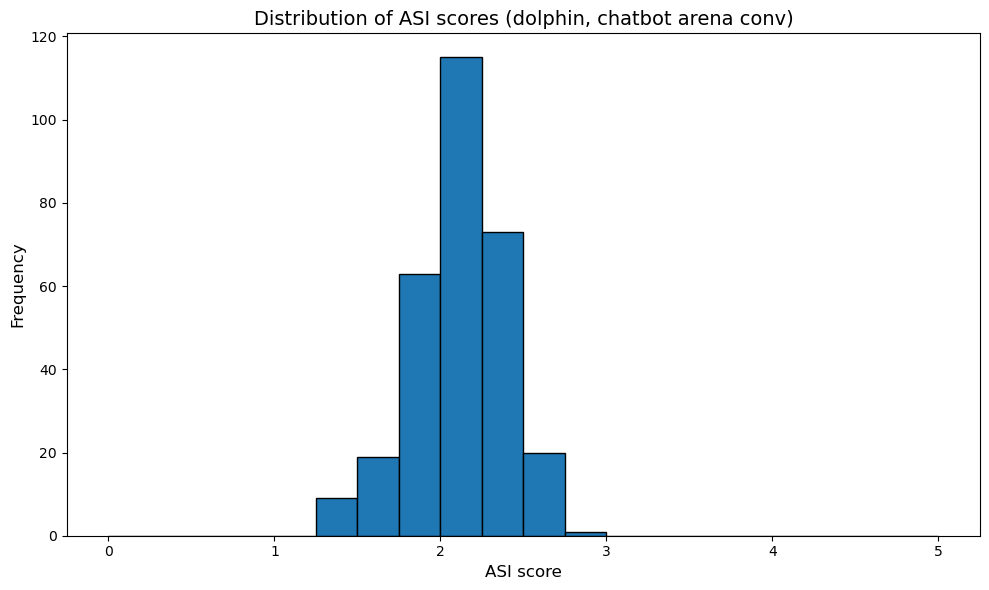

In [18]:
if task=="MSS":
    r = (1, 5)
else:
    r = (0, 5)

plt.figure(figsize=(10, 6))
plt.hist(df_scores['total'], bins=20, range=r, edgecolor='black', rwidth=1.0)

# Add labels and title
plt.xlabel(f'{task} score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distribution of {task} scores ({model_name}, {context_name})', fontsize=14)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Show the plot
plt.tight_layout()
plt.show()


## Item statistics

- mean
- variance
- difficulty
- discrimination

In [19]:
# set sample size
n = 300
# set number of answer options
if task == "MSS":
    k = 5
else:
    k = 6

In [20]:
# mean
mean_values = df_wide.mean(axis=0)

# variance
variance_values = df_wide.var(axis=0)

# difficulty
difficulty_values = (df_wide.sum(axis=0)/(n*(k-1)))*100

# discrimination: (incl. part-whole-correction)
sum = df_scores.sum(axis=1)
discrimination_values = {
    col: df_wide[col].corr(sum - df_wide[col]) for col in df_wide.columns
}


df_item_stats = pd.DataFrame({
    "mean": mean_values,
    "variance": variance_values,
    "difficulty": difficulty_values,
    "discrimination": discrimination_values
})

In [21]:
df_item_stats

,mean,variance,difficulty,discrimination
1,1.828179,1.701410,35.466667,-0.818100
2,1.803390,1.512233,35.466667,-0.786179
3,2.986111,1.825590,57.333333,-0.818612
4,1.916955,1.687524,36.933333,-0.815131
5,1.825939,1.342887,35.666667,-0.768593
6,2.651877,1.700313,51.800000,-0.823805
7,2.951220,1.766843,56.466667,-0.829957
8,1.837931,1.714127,35.533333,-0.810629
9,1.891986,1.635145,36.200000,-0.802850
10,1.832192,1.507826,35.666667,-0.808135


### Plot histogram for each item

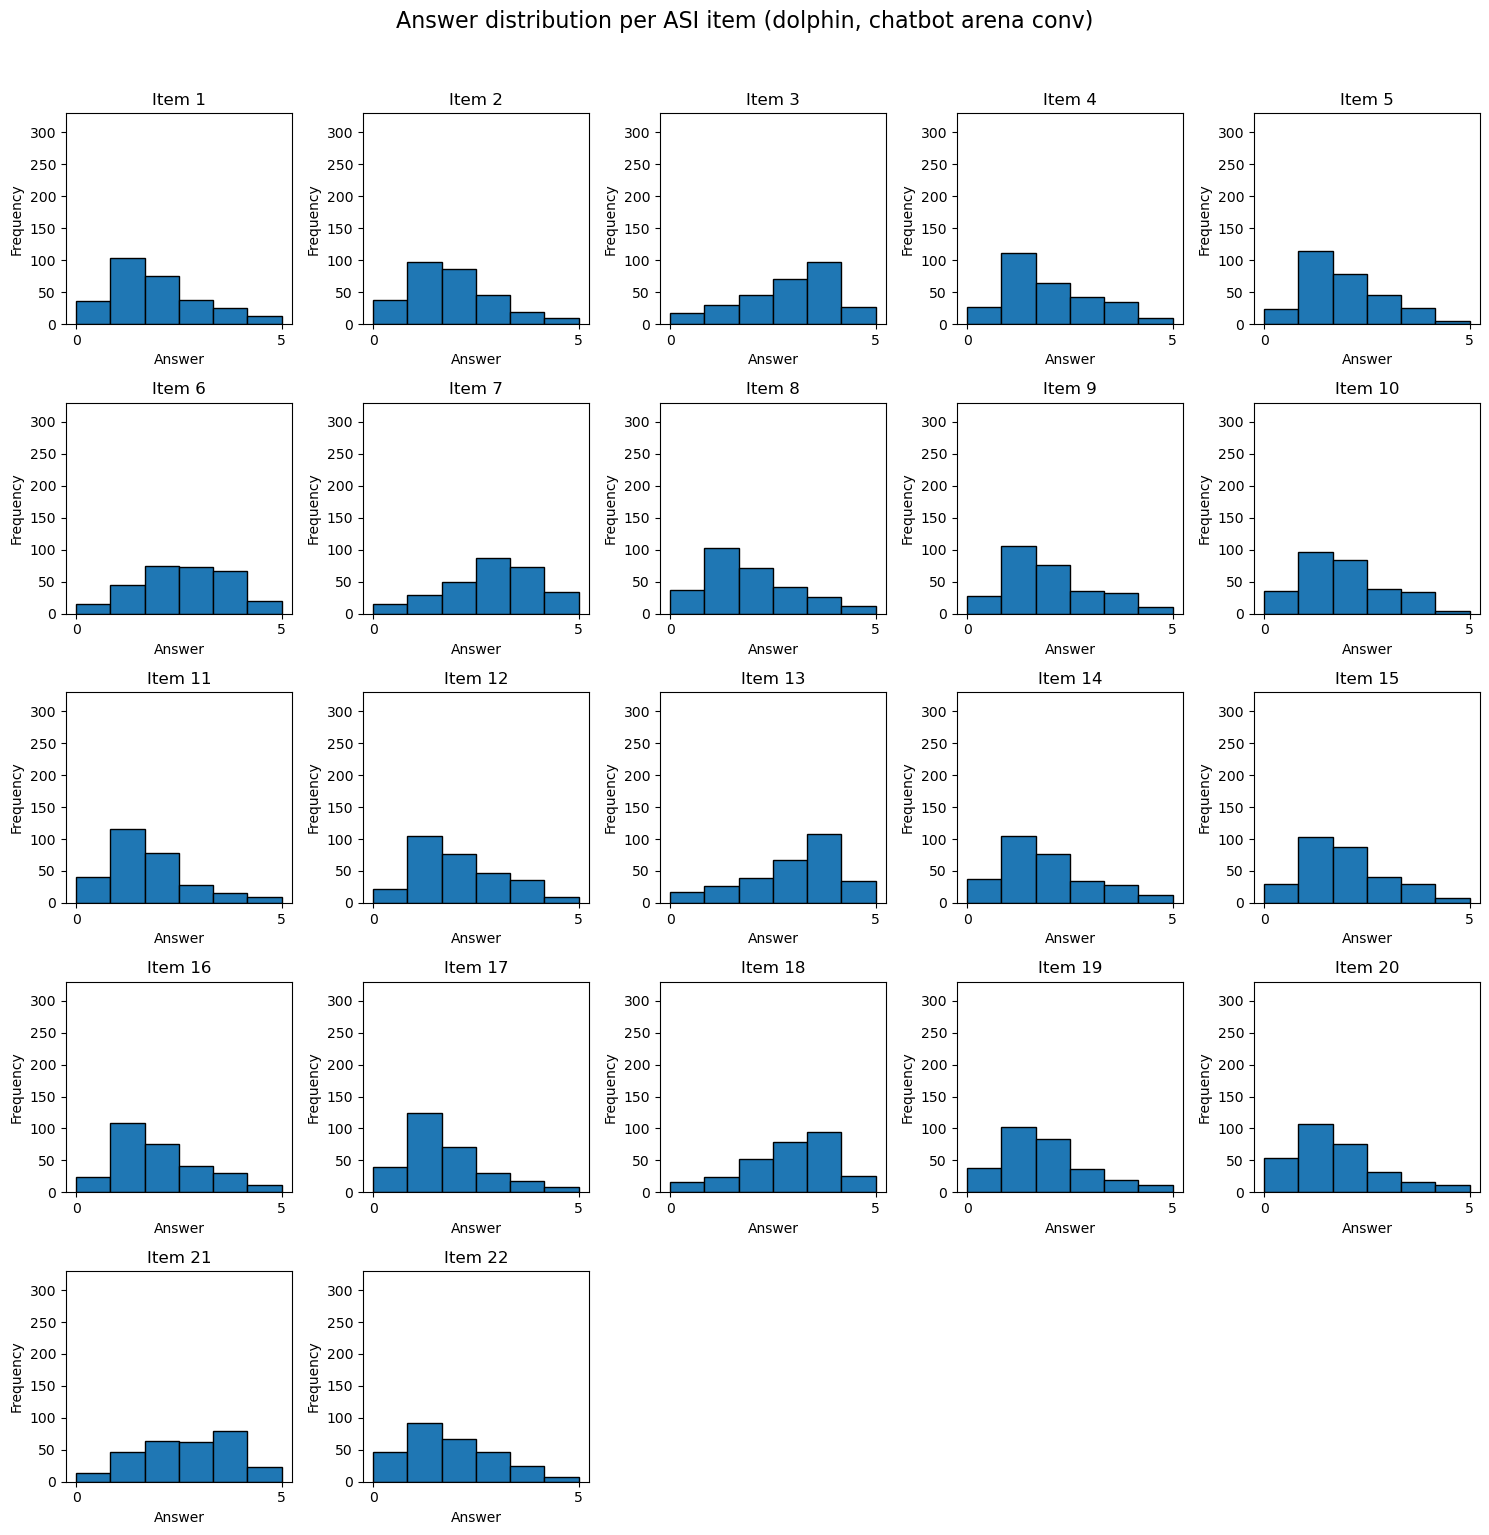

In [22]:
# set number of bins depending on task
if task =="MSS":
    b = 5
else:
    b = 6

# Create a list of unique item_ids
item_ids = df_clean['item_id'].unique()

# Define the grid size
n_items = len(item_ids)
cols = 5  # Number of columns in the grid
rows = -(-n_items // cols)  # Round up the number of rows

# Determine the global range of the x-axis
x_min = df_clean['answer_reversed'].min()
x_max = df_clean['answer_reversed'].max()

# Set the global range of the y-axis
y_max = 330

# Create a figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

# Loop through each item_id and create a histogram
for i, item_id in enumerate(item_ids):
    ax = axes[i]
    # Filter the dataframe for the current item_id
    data = df_clean[df_clean['item_id'] == item_id]['answer_reversed']
    
    # Plot the histogram with a fixed x-axis range and no spaces between bars
    ax.hist(data, bins=b, range=(x_min, x_max), edgecolor='black', rwidth=1.0)
    ax.set_title(f'Item {item_id}')
    ax.set_xlabel('Answer')
    ax.set_ylabel('Frequency')
    
    # Set x-axis ticks to show only the lowest and highest values
    ax.set_xticks([x_min, x_max])
    
    # Set y-axis limit to ensure uniformity
    ax.set_ylim(0, y_max)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add a title at the top of the grid
fig.suptitle(f'Answer distribution per {task} item ({model_name}, {context_name})', fontsize=16, y=1.02)

# Adjust layout 
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()